# Import Required Libraries
Import the necessary libraries, including OpenCV and matplotlib.

In [ ]:
# Import Required Libraries
import cv2  # OpenCV for computer vision tasks
import matplotlib.pyplot as plt  # Matplotlib for plotting images
import os  # OS module for file operations
import pandas as pd
import numpy as np
import utils  # Custom utility functions


# Changing the structure of the dataset files

In [ ]:
# Specify the source and target directories
source_directory = os.path.join('data', 'isolated_words_per_user')
target_directory = os.path.join('data', 'original')

# Collect images
utils.collect_images_and_copy_to_original(source_directory, target_directory)

# Load Images from File
Load the images from the specified file directory.

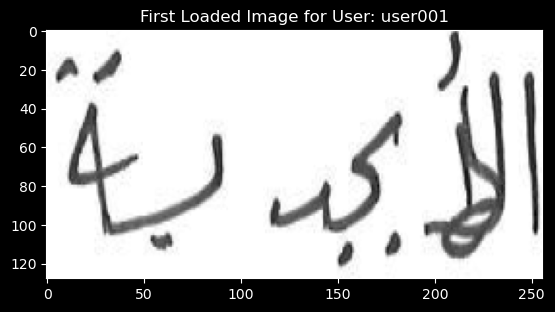

In [2]:

# Load Images from File
def load_images_from_directory(directory, target_size=(256, 128)):
    data = []
    for root, _, files in os.walk(directory):
            
        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img = cv2.imread(os.path.join(root, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                            
                    img_resized = cv2.resize(img, target_size)
                    data.append({'filename': filename, 'image': img_resized})
    return data

# Specify the directory containing images
image_directory = os.path.join('data', 'original')

# Load images
images_data = load_images_from_directory(image_directory)

# Convert to DataFrame
df = pd.DataFrame(images_data)
df.set_index('filename', inplace=True)
df['Target'] = df.index.map(lambda x: x.split('_')[0])

# Display the first image to verify
if not df.empty:
    first_user = df['Target'].iloc[0]
    first_image = df.iloc[0]['image']
    plt.imshow(first_image, cmap='gray')
    plt.title(f'First Loaded Image for User: {first_user}')
    plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8144 entries, user001_abjadiyah_031.png to user082_shateerah_040.png
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   8144 non-null   object
 1   Target  8144 non-null   object
dtypes: object(2)
memory usage: 190.9+ KB


# Initialize ORB Detector
Initialize the ORB detector using OpenCV.

In [4]:
# Initialize ORB Detector
# Initialize ORB Detector with custom parameters
orb = cv2.ORB_create(
    nfeatures=1000,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=15,
    firstLevel=0,
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE,
    patchSize=15,
    fastThreshold=10
)

# Apply ORB to Each Image
Apply the ORB detector to each image to find keypoints and descriptors.

In [5]:
# Apply ORB to Each Image and store keypoints and descriptors
def apply_orb(row):
    image = row['image']
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

# Apply the function to each row in the DataFrame
df[['keypoints', 'descriptors']] = df.apply(lambda row: pd.Series(apply_orb(row)), axis=1)



In [6]:
# Display the first image's keypoints to verify

def display_image_with_keypoints(index):
    if not df.empty:

        first_user = df['Target'].iloc[index]
        first_keypoints = df.iloc[index]['keypoints']
        first_image = cv2.drawKeypoints(df.iloc[index]['image'], first_keypoints, None, color=(0, 255, 0), flags=0)
        plt.imshow(first_image, cmap='gray')
        plt.title(f'Image Keypoints for User: {first_user}')
        plt.show()

In [10]:
df.head()

,image,Target,keypoints,descriptors
filename,,,,
user001_abjadiyah_031.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",user001,"(< cv2.KeyPoint 0x7f47005d6880>, < cv2.KeyPoin...","[[131, 220, 151, 188, 246, 132, 169, 183, 158,..."
user001_abjadiyah_032.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",user001,"(< cv2.KeyPoint 0x7f46f4b20cf0>, < cv2.KeyPoin...","[[3, 205, 98, 216, 86, 145, 188, 231, 76, 64, ..."
user001_abjadiyah_033.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",user001,"(< cv2.KeyPoint 0x7f46e7b04630>, < cv2.KeyPoin...","[[34, 95, 98, 12, 118, 211, 190, 103, 29, 68, ..."
user001_abjadiyah_034.png,"[[250, 253, 253, 252, 251, 249, 248, 250, 250,...",user001,"(< cv2.KeyPoint 0x7f46e7b075d0>, < cv2.KeyPoin...","[[2, 141, 34, 156, 148, 131, 174, 103, 84, 65,..."
user001_abjadiyah_035.png,"[[255, 255, 255, 255, 255, 255, 253, 250, 252,...",user001,"(< cv2.KeyPoint 0x7f46e7b128e0>, < cv2.KeyPoin...","[[2, 89, 50, 204, 109, 213, 152, 80, 137, 76, ..."


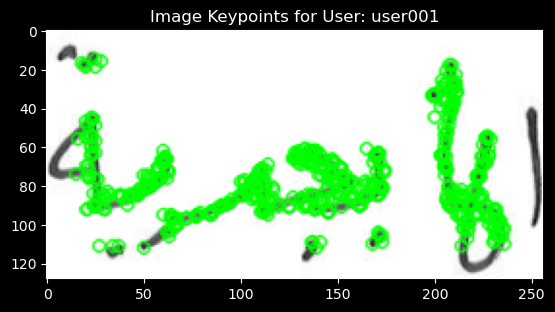

In [7]:
display_image_with_keypoints(4)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8144 entries, user001_abjadiyah_031.png to user082_shateerah_040.png
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        8144 non-null   object
 1   Target       8144 non-null   object
 2   keypoints    8144 non-null   object
 3   descriptors  8144 non-null   object
dtypes: object(4)
memory usage: 318.1+ KB


In [15]:
# Extract all descriptors
from sklearn.cluster import KMeans


all_descriptors = []
for descriptors in df['descriptors']:
    if descriptors is not None:
        all_descriptors.extend(descriptors)

all_descriptors = np.array(all_descriptors)

# Cluster Descriptors using KMeans
num_clusters = 50  # Number of visual words
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(all_descriptors)

# Create histograms for each image
def create_histogram(descriptors, kmeans, num_clusters):
    histogram = np.zeros(num_clusters)
    if descriptors is not None:
        clusters = kmeans.predict(descriptors)
        for cluster in clusters:
            histogram[cluster] += 1
    return histogram

df['histogram'] = df['descriptors'].apply(lambda descriptors: create_histogram(descriptors, kmeans, num_clusters))


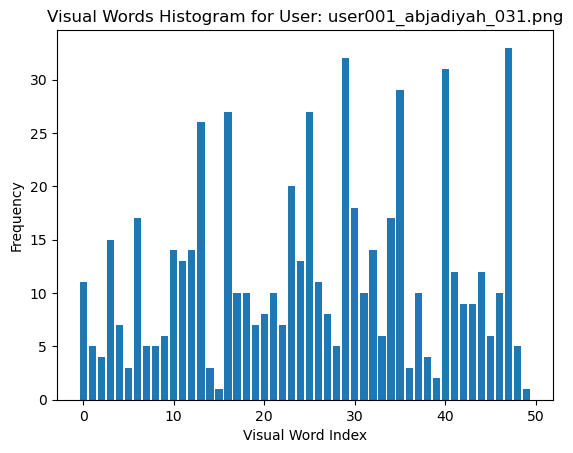

In [16]:
# Drop the original keypoints and descriptors columns
df.drop(columns=['keypoints', 'descriptors'], inplace=True)

# Display the first histogram to verify
if not df.empty:
    first_user = df.index[0]
    first_histogram = df.iloc[0]['histogram']
    plt.bar(range(num_clusters), first_histogram)
    plt.title(f'Visual Words Histogram for User: {first_user}')
    plt.xlabel('Visual Word Index')
    plt.ylabel('Frequency')
    plt.show()